# Imports

In [2]:
from collections import Counter
import os
import re
import json
from pathlib import Path

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss

import nltk
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from datasets import load_dataset, DownloadMode, Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline

import evaluate
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Make Dirs

In [3]:
HIST:str = 'history'
OUT:str = 'outputs_new'

In [4]:
if not os.path.isdir(HIST):
      os.makedirs(HIST)
      print("Directory for saving histories created successfully!")
else:
      print("History directory already exists!")

History directory already exists!


In [5]:
if not os.path.isdir(OUT):
      os.makedirs(OUT)
      print("Directory for saving outputs created successfully!")
else:
      print("Output directory already exists!")

Output directory already exists!


In [6]:
HIST_PATH:str = HIST+'/'
OUT_PATH:str = OUT+'/'
ANNOTATIONS_PATH:str = 'annotations.csv'

# Load Data

In [7]:
filepath = r'C:\nlp_data\amazon_reviews'

destination_path = str(Path(filepath))

os.makedirs(destination_path, exist_ok=True)

dataset = load_dataset(
    "McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", 
    cache_dir=destination_path,
    download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS 
)

In [8]:
def json_to_df() -> pd.DataFrame:
    df = dataset["full"].to_pandas()

    if 'images' in df.columns:
        images_df = pd.json_normalize(df['images'])  
        df = pd.concat([df.drop(columns=['images']), images_df], axis=1)  

    return df

DF:pd.DataFrame = json_to_df()
display(DF.loc[:2])

,rating,title,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...,B00YQ6X8EO,B00YQ6X8EO,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588687728923,0,True
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just...",B081TJ8YS3,B081TJ8YS3,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1588615855070,1,True
2,5.0,Yes!,"Smells good, feels great!",B07PNNCSP9,B097R46CSY,AE74DYR3QUGVPZJ3P7RFWBGIX7XQ,1589665266052,2,True


# Clean Data

In [9]:
print(DF.isna().sum())

rating               0
title                0
text                 0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


In [10]:
def trim_cols(data:pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame(data, columns=['rating', 'title', 'text'])

    return df

DF:pd.DataFrame = trim_cols(DF)
display(DF.head(3))

,rating,title,text
0,5.0,Such a lovely scent but not overpowering.,This spray is really nice. It smells really go...
1,4.0,Works great but smells a little weird.,"This product does what I need it to do, I just..."
2,5.0,Yes!,"Smells good, feels great!"


# Get 100 Low Ratings

In [11]:
def get_low_ratings(df:pd.DataFrame, rows:tuple[int, int], col:str, rating:float) -> pd.DataFrame:
    low_ratings = df.loc[df[col] == rating]
    
    return low_ratings[rows[0]:rows[1]]

DF:pd.DataFrame = get_low_ratings(DF, (0,100), 'rating', 1.0)
display(DF.head(3))

,rating,title,text
3,1.0,Synthetic feeling,Felt synthetic
27,1.0,not what it claims to do,nothing special unfortunately i waited too lo...
32,1.0,halo hair extensions,"This halo hair extension is simply put, garbag..."


In [12]:
low_ratings = DF.loc[DF['rating'] == 1.0]
display(low_ratings[90:100])

,rating,title,text
1451,1.0,Would not buy again,Does nothing for my daughters thin curly hair....
1480,1.0,Not the original fragrance,Does not smell like the original Maja fragranc...
1485,1.0,Did not work for me,Let me begin this review by stating that I hav...
1500,1.0,Could be refurbished on arrival,Very cheaply made. The motor went out two week...
1504,1.0,Pink pallette,"Returned, not as described."
1522,1.0,One Star,Felt like a limp piece of cheap fabric. Have t...
1554,1.0,very poor quality and I suggest saving your money,You can hardly see the images! very poor quali...
1567,1.0,Does Nothing for Me!,This doesn’t work for me as well as the 3 day ...
1571,1.0,China junk,I never even opened these up because come to f...
1579,1.0,They are too wide for my eyes; they are NOT re...,They are too wide for my eyes/ they are are NO...


# Merge with Annotations

In [13]:
def get_annotations(file_path:str=ANNOTATIONS_PATH) -> pd.DataFrame:
    annotations = pd.read_csv(file_path)

    return annotations

def get_annotated_data(annotations:pd.DataFrame=get_annotations(), original_data:pd.DataFrame=DF) -> pd.DataFrame:
    annotated_data = original_data.loc[original_data.index.isin(annotations['id'])]
    annotated_data = annotated_data.reset_index().merge(annotations, left_on='index', right_on='id')

    return annotated_data

DF:pd.DataFrame = get_annotated_data()
display(DF)

,index,rating,title,text,id,pricing,quality,delivery,service,usability,mismatch,packaging
0,3,1.0,Synthetic feeling,Felt synthetic,3,0,1,0,0,0,0,0
1,27,1.0,not what it claims to do,nothing special unfortunately i waited too lo...,27,0,1,0,0,1,1,0
2,32,1.0,halo hair extensions,"This halo hair extension is simply put, garbag...",32,0,1,0,0,1,1,0
3,39,1.0,Don’t bother,Normally I like NYX products but not this one....,39,0,0,0,0,1,1,0
4,46,1.0,waste of money,Plastic does not bend for matching your brows ...,46,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1522,1.0,One Star,Felt like a limp piece of cheap fabric. Have t...,1522,0,1,0,0,0,0,0
96,1554,1.0,very poor quality and I suggest saving your money,You can hardly see the images! very poor quali...,1554,0,1,0,0,0,0,0
97,1567,1.0,Does Nothing for Me!,This doesn’t work for me as well as the 3 day ...,1567,0,1,0,0,0,0,0
98,1571,1.0,China junk,I never even opened these up because come to f...,1571,0,1,0,0,0,0,0


In [14]:
DF  = pd.DataFrame(DF, columns=['id', 'text', 'pricing', 'quality',  'delivery', 'service', 'usability', 'mismatch', 'packaging'])

In [15]:
display(DF.head(3))

,id,text,pricing,quality,delivery,service,usability,mismatch,packaging
0,3,Felt synthetic,0,1,0,0,0,0,0
1,27,nothing special unfortunately i waited too lo...,0,1,0,0,1,1,0
2,32,"This halo hair extension is simply put, garbag...",0,1,0,0,1,1,0


# Compute Balanced Class Weights

In [16]:
label_columns = ['pricing', 'quality', 'delivery', 'service', 'usability', 'mismatch', 'packaging']
label_data = DF[label_columns]

n_samples = len(DF)

# Calculate class frequencies (sum of 1s for each label)
class_counts = label_data.sum(axis=0).values

# Compute class weights
class_weights = n_samples / (2.0 * class_counts)

# Create a dictionary mapping labels to weights
class_weights_dict = {label: weight for label, weight in zip(label_columns, class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {'pricing': 8.333333333333334, 'quality': 0.8771929824561403, 'delivery': 6.25, 'service': 12.5, 'usability': 1.0416666666666667, 'mismatch': 2.5, 'packaging': 5.0}


# Text Processing

In [17]:
def preprocess_text(text):
    try:
        text = BeautifulSoup(text, "html.parser").get_text()  
        text = re.sub(r'http\S+', '', text)  
        return text.strip()
    
    except Exception as e:
        print(f"Error processing text: {text} - {e}")
        return ""

In [18]:
DF['text'] = DF['text'].apply(preprocess_text)
display(DF.head(3))

,id,text,pricing,quality,delivery,service,usability,mismatch,packaging
0,3,Felt synthetic,0,1,0,0,0,0,0
1,27,nothing special unfortunately i waited too lo...,0,1,0,0,1,1,0
2,32,"This halo hair extension is simply put, garbag...",0,1,0,0,1,1,0


# Split dataset using Cross Validation

In [19]:
stratification_target = DF[label_columns].sum(axis=1).astype(int)

n_splits = 10  
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(DF, stratification_target)):
    train_data = DF.iloc[train_idx]
    val_data = DF.iloc[val_idx]
    
    print(f"Fold {fold_idx + 1}")
    print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}")

Fold 1
Train size: 90, Validation size: 10
Fold 2
Train size: 90, Validation size: 10
Fold 3
Train size: 90, Validation size: 10
Fold 4
Train size: 90, Validation size: 10
Fold 5
Train size: 90, Validation size: 10
Fold 6
Train size: 90, Validation size: 10
Fold 7
Train size: 90, Validation size: 10
Fold 8
Train size: 90, Validation size: 10
Fold 9
Train size: 90, Validation size: 10
Fold 10
Train size: 90, Validation size: 10


In [20]:
np.shape(train_data)

(90, 9)

In [21]:
np.shape(val_data)

(10, 9)

# Plot Sequence Length

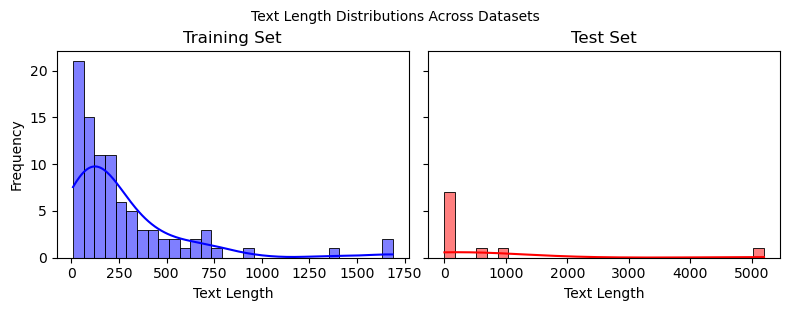

In [22]:
def plot_sequence_distributions(train: pd.DataFrame, test: pd.DataFrame, name:str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    
    sns.histplot(train['text'].apply(len), bins=30, kde=True, color='blue', ax=axes[0])
    axes[0].set_title('Training Set')
    axes[0].set_xlabel('Text Length')
    axes[0].set_ylabel('Frequency')
    
    sns.histplot(test['text'].apply(len), bins=30, kde=True, color='red', ax=axes[1])
    axes[1].set_title('Test Set')
    axes[1].set_xlabel('Text Length')
    axes[1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.suptitle('Text Length Distributions Across Datasets', y=1.02, fontsize=10)
    plt.savefig(OUT_PATH + name + '.jpg')
    plt.show()

plot_sequence_distributions(train_data, val_data, 'sequence_length')

# Convert Dataframes to Dataset

In [23]:
train_data.columns

Index(['id', 'text', 'pricing', 'quality', 'delivery', 'service', 'usability',
       'mismatch', 'packaging'],
      dtype='object')

In [24]:
train_dataset = Dataset.from_pandas(train_data, preserve_index=False)
test_dataset = Dataset.from_pandas(val_data, preserve_index=False)

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
})

print(dataset['train'])
print(dataset['test'])

Dataset({
    features: ['id', 'text', 'pricing', 'quality', 'delivery', 'service', 'usability', 'mismatch', 'packaging'],
    num_rows: 90
})
Dataset({
    features: ['id', 'text', 'pricing', 'quality', 'delivery', 'service', 'usability', 'mismatch', 'packaging'],
    num_rows: 10
})


# Get Labels

In [25]:
labels = [label for label in dataset['train'].features.keys() if label not in ['id', 'text']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
label2id

{'pricing': 0,
 'quality': 1,
 'delivery': 2,
 'service': 3,
 'usability': 4,
 'mismatch': 5,
 'packaging': 6}

# Plot model performance

#### Plot singular training results

In [26]:
def plot_training_result(history, model_name:str, file_name: str) -> None:
    train_loss = history[history['train_loss'].notnull()][['epoch', 'train_loss']]
    eval_loss = history[history['eval_loss'].notnull()][['epoch', 'eval_loss']]
    accuracy = history[history['eval_accuracy'].notnull()][['epoch', 'eval_accuracy']]

    plt.figure(figsize=(8, 3))

    # Subplot 1: Loss (Train vs. Eval Loss)
    plt.subplot(1, 2, 1)
    plt.plot(train_loss['epoch'], train_loss['train_loss'], label="Train Loss", marker='o')
    plt.plot(eval_loss['epoch'], eval_loss['eval_loss'], label="Eval Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name}: Train and Eval Loss")
    plt.legend()

    # Subplot 2: Accuracy (Evaluation Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(accuracy['epoch'], accuracy['eval_accuracy'], label="Eval Accuracy", marker='o', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name}: Eval Accuracy")
    plt.legend()

    plt.ylim(0, 1)  # Set y-axis range to 0 to 1 (as accuracy is typically a fraction)
    plt.yticks([i / 10 for i in range(11)], [f"{i * 10}%" for i in range(11)]) 
    plt.tight_layout()
    plt.savefig(OUT_PATH + file_name + '.jpg')
    plt.show()


#### Plot training results for BERT, DeBERTa, and DistilBERT

In [27]:
def plot_all_results(hist1, hist2, hist3, name1: str, name2: str, name3: str, file_name: str) -> None:
    train_loss_1 = hist1[hist1['train_loss'].notnull()][['epoch', 'train_loss']]
    eval_loss_1 = hist1[hist1['eval_loss'].notnull()][['epoch', 'eval_loss']]
    accuracy_1 = hist1[hist1['eval_accuracy'].notnull()][['epoch', 'eval_accuracy']]
    f1_1 = hist1[hist1['eval_f1'].notnull()][['epoch', 'eval_f1']]
    precision_1 = hist1[hist1['eval_precision'].notnull()][['epoch', 'eval_precision']]
    recall_1 = hist1[hist1['eval_recall'].notnull()][['epoch', 'eval_recall']]

    train_loss_2 = hist2[hist2['train_loss'].notnull()][['epoch', 'train_loss']]
    eval_loss_2 = hist2[hist2['eval_loss'].notnull()][['epoch', 'eval_loss']]
    accuracy_2 = hist2[hist2['eval_accuracy'].notnull()][['epoch', 'eval_accuracy']]
    f1_2 = hist2[hist2['eval_f1'].notnull()][['epoch', 'eval_f1']]
    precision_2 = hist2[hist2['eval_precision'].notnull()][['epoch', 'eval_precision']]
    recall_2 = hist2[hist2['eval_recall'].notnull()][['epoch', 'eval_recall']]

    train_loss_3 = hist3[hist3['train_loss'].notnull()][['epoch', 'train_loss']]
    eval_loss_3 = hist3[hist3['eval_loss'].notnull()][['epoch', 'eval_loss']]
    accuracy_3 = hist3[hist3['eval_accuracy'].notnull()][['epoch', 'eval_accuracy']]
    f1_3 = hist3[hist3['eval_f1'].notnull()][['epoch', 'eval_f1']]
    precision_3 = hist3[hist3['eval_precision'].notnull()][['epoch', 'eval_precision']]
    recall_3 = hist3[hist3['eval_recall'].notnull()][['epoch', 'eval_recall']]

    plt.figure(figsize=(12, 8))

    # Subplot 1: Loss (Train vs. Eval Loss)
    plt.subplot(2, 2, 1)
    plt.plot(train_loss_1['epoch'], train_loss_1['train_loss'], label=f"{name1} Train Loss", marker='o')
    plt.plot(eval_loss_1['epoch'], eval_loss_1['eval_loss'], label=f"{name1} Eval Loss", marker='x')
    plt.plot(train_loss_2['epoch'], train_loss_2['train_loss'], label=f"{name2} Train Loss", marker='o')
    plt.plot(eval_loss_2['epoch'], eval_loss_2['eval_loss'], label=f"{name2} Eval Loss", marker='x')
    plt.plot(train_loss_3['epoch'], train_loss_3['train_loss'], label=f"{name3} Train Loss", marker='o')
    plt.plot(eval_loss_3['epoch'], eval_loss_3['eval_loss'], label=f"{name3} Eval Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss")
    plt.legend()

    # Subplot 2: Evaluation Metrics (Accuracy, F1, Precision, Recall)
    plt.subplot(2, 2, 2)
    plt.plot(accuracy_1['epoch'], accuracy_1['eval_accuracy'], label=f"{name1} Accuracy", marker='o')
    plt.plot(f1_1['epoch'], f1_1['eval_f1'], label=f"{name1} F1", marker='x')
    plt.plot(precision_1['epoch'], precision_1['eval_precision'], label=f"{name1} Precision", marker='^')
    plt.plot(recall_1['epoch'], recall_1['eval_recall'], label=f"{name1} Recall", marker='s')

    plt.plot(accuracy_2['epoch'], accuracy_2['eval_accuracy'], label=f"{name2} Accuracy", marker='o')
    plt.plot(f1_2['epoch'], f1_2['eval_f1'], label=f"{name2} F1", marker='x')
    plt.plot(precision_2['epoch'], precision_2['eval_precision'], label=f"{name2} Precision", marker='^')
    plt.plot(recall_2['epoch'], recall_2['eval_recall'], label=f"{name2} Recall", marker='s')

    plt.plot(accuracy_3['epoch'], accuracy_3['eval_accuracy'], label=f"{name3} Accuracy", marker='o')
    plt.plot(f1_3['epoch'], f1_3['eval_f1'], label=f"{name3} F1", marker='x')
    plt.plot(precision_3['epoch'], precision_3['eval_precision'], label=f"{name3} Precision", marker='^')
    plt.plot(recall_3['epoch'], recall_3['eval_recall'], label=f"{name3} Recall", marker='s')

    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.title("Evaluation Metrics (Accuracy, F1, Precision, Recall)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(OUT_PATH + file_name + '.jpg')
    plt.show()

# Evaluate Model Performance

In [28]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Convert predictions and labels to NumPy arrays
    predictions = np.array(predictions)
    labels = np.array(labels)
    
    # Apply sigmoid to predictions
    predictions = sigmoid(predictions)
    
    # Threshold predictions to binary labels
    predictions = (predictions > 0.5).astype(int).reshape(-1)
    
    # Compute metrics
    return clf_metrics.compute(predictions=predictions, references=labels.reshape(-1))

# 1. BERT

In [29]:
bert_name = 'bert-base-uncased' 
bert_tokenizer = AutoTokenizer.from_pretrained(bert_name)

In [30]:
def preprocess_data(example):
  text = example["text"]
  encoding = bert_tokenizer(text, padding="max_length", truncation=True, max_length=200)

  current_labels = []
  for k in labels:
    if example[k]:
      current_labels.append(1.)
    else:
      current_labels.append(0.)
  encoding["labels"] = current_labels

  return encoding

bert_dataset = dataset.map(preprocess_data)
data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer)

Map: 100%|██████████| 10/10 [00:00<00:00, 1480.73 examples/s]


In [31]:
print(f"Tokenizer vocabulary size: {bert_tokenizer.vocab_size}")

Tokenizer vocabulary size: 30522


In [32]:
bert_dataset['train'][0]

{'id': 3,
 'text': 'Felt synthetic',
 'pricing': 0,
 'quality': 1,
 'delivery': 0,
 'service': 0,
 'usability': 0,
 'mismatch': 0,
 'packaging': 0,
 'input_ids': [101,
  2371,
  12553,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [33]:
bert_dataset['test'][0]

{'id': 372,
 'text': 'This is a joke. They do not work. Do not waste time or money.',
 'pricing': 0,
 'quality': 0,
 'delivery': 0,
 'service': 0,
 'usability': 1,
 'mismatch': 0,
 'packaging': 0,
 'input_ids': [101,
  2023,
  2003,
  1037,
  8257,
  1012,
  2027,
  2079,
  2025,
  2147,
  1012,
  2079,
  2025,
  5949,
  2051,
  2030,
  2769,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [34]:
bert = AutoModelForSequenceClassification.from_pretrained(bert_name,
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
bert_args = TrainingArguments(
    output_dir="history/bert",
    learning_rate=2e-5,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [36]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # BCEWithLogitsLoss for multi-label classification
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels.float())  

        return (loss, outputs) if return_outputs else loss

bert_trainer = CustomTrainer(
    model=bert,
    args=bert_args,
    train_dataset=bert_dataset['train'],
    eval_dataset=bert_dataset['test'],
    tokenizer=bert_tokenizer,
    compute_metrics=compute_metrics,
)

In [37]:
bert_trainer.train()

                                                
 10%|█         | 30/300 [00:40<05:38,  1.25s/it]

{'eval_loss': 0.5199551582336426, 'eval_accuracy': 0.7714285714285715, 'eval_f1': 0.3333333333333333, 'eval_precision': 0.5714285714285714, 'eval_recall': 0.23529411764705882, 'eval_runtime': 1.0668, 'eval_samples_per_second': 9.374, 'eval_steps_per_second': 3.75, 'epoch': 1.0}


                                                
 20%|██        | 60/300 [01:20<04:59,  1.25s/it]

{'eval_loss': 0.48481082916259766, 'eval_accuracy': 0.7285714285714285, 'eval_f1': 0.42424242424242425, 'eval_precision': 0.4375, 'eval_recall': 0.4117647058823529, 'eval_runtime': 1.0886, 'eval_samples_per_second': 9.186, 'eval_steps_per_second': 3.675, 'epoch': 2.0}


                                                
 30%|███       | 90/300 [02:02<04:41,  1.34s/it]

{'eval_loss': 0.47593721747398376, 'eval_accuracy': 0.7571428571428571, 'eval_f1': 0.37037037037037035, 'eval_precision': 0.5, 'eval_recall': 0.29411764705882354, 'eval_runtime': 1.1432, 'eval_samples_per_second': 8.747, 'eval_steps_per_second': 3.499, 'epoch': 3.0}


                                                 
 40%|████      | 120/300 [02:44<03:56,  1.32s/it]

{'eval_loss': 0.4760940968990326, 'eval_accuracy': 0.7571428571428571, 'eval_f1': 0.45161290322580644, 'eval_precision': 0.5, 'eval_recall': 0.4117647058823529, 'eval_runtime': 1.1359, 'eval_samples_per_second': 8.803, 'eval_steps_per_second': 3.521, 'epoch': 4.0}


                                                 
 50%|█████     | 150/300 [03:30<03:20,  1.33s/it]

{'eval_loss': 0.4747503399848938, 'eval_accuracy': 0.7, 'eval_f1': 0.36363636363636365, 'eval_precision': 0.375, 'eval_recall': 0.35294117647058826, 'eval_runtime': 1.1611, 'eval_samples_per_second': 8.612, 'eval_steps_per_second': 3.445, 'epoch': 5.0}


                                                 
 60%|██████    | 180/300 [04:12<02:40,  1.33s/it]

{'eval_loss': 0.47592440247535706, 'eval_accuracy': 0.7, 'eval_f1': 0.3225806451612903, 'eval_precision': 0.35714285714285715, 'eval_recall': 0.29411764705882354, 'eval_runtime': 1.1427, 'eval_samples_per_second': 8.751, 'eval_steps_per_second': 3.501, 'epoch': 6.0}


                                                 
 70%|███████   | 210/300 [04:54<01:53,  1.26s/it]

{'eval_loss': 0.4775921702384949, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.35714285714285715, 'eval_precision': 0.45454545454545453, 'eval_recall': 0.29411764705882354, 'eval_runtime': 1.0902, 'eval_samples_per_second': 9.173, 'eval_steps_per_second': 3.669, 'epoch': 7.0}


                                                 
 80%|████████  | 240/300 [05:36<01:18,  1.30s/it]

{'eval_loss': 0.478679358959198, 'eval_accuracy': 0.7285714285714285, 'eval_f1': 0.3448275862068966, 'eval_precision': 0.4166666666666667, 'eval_recall': 0.29411764705882354, 'eval_runtime': 1.0913, 'eval_samples_per_second': 9.164, 'eval_steps_per_second': 3.665, 'epoch': 8.0}


                                                 
 90%|█████████ | 270/300 [06:15<00:36,  1.20s/it]

{'eval_loss': 0.4756355881690979, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.35714285714285715, 'eval_precision': 0.45454545454545453, 'eval_recall': 0.29411764705882354, 'eval_runtime': 1.0136, 'eval_samples_per_second': 9.866, 'eval_steps_per_second': 3.946, 'epoch': 9.0}


                                                 
100%|██████████| 300/300 [06:58<00:00,  1.22s/it]

{'eval_loss': 0.47744327783584595, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.35714285714285715, 'eval_precision': 0.45454545454545453, 'eval_recall': 0.29411764705882354, 'eval_runtime': 1.1118, 'eval_samples_per_second': 8.994, 'eval_steps_per_second': 3.598, 'epoch': 10.0}


100%|██████████| 300/300 [07:14<00:00,  1.45s/it]

{'train_runtime': 434.9367, 'train_samples_per_second': 2.069, 'train_steps_per_second': 0.69, 'train_loss': 0.36647905985514323, 'epoch': 10.0}


TrainOutput(global_step=300, training_loss=0.36647905985514323, metrics={'train_runtime': 434.9367, 'train_samples_per_second': 2.069, 'train_steps_per_second': 0.69, 'total_flos': 92504133000000.0, 'train_loss': 0.36647905985514323, 'epoch': 10.0})

In [38]:
bert_metrics = bert_trainer.evaluate()
print(bert_metrics)

100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

{'eval_loss': 0.4747503399848938, 'eval_accuracy': 0.7, 'eval_f1': 0.36363636363636365, 'eval_precision': 0.375, 'eval_recall': 0.35294117647058826, 'eval_runtime': 1.0535, 'eval_samples_per_second': 9.492, 'eval_steps_per_second': 3.797, 'epoch': 10.0}


In [39]:
pprint.pprint(bert_trainer.state.log_history)

[{'epoch': 1.0,
  'eval_accuracy': 0.7714285714285715,
  'eval_f1': 0.3333333333333333,
  'eval_loss': 0.5199551582336426,
  'eval_precision': 0.5714285714285714,
  'eval_recall': 0.23529411764705882,
  'eval_runtime': 1.0668,
  'eval_samples_per_second': 9.374,
  'eval_steps_per_second': 3.75,
  'step': 30},
 {'epoch': 2.0,
  'eval_accuracy': 0.7285714285714285,
  'eval_f1': 0.42424242424242425,
  'eval_loss': 0.48481082916259766,
  'eval_precision': 0.4375,
  'eval_recall': 0.4117647058823529,
  'eval_runtime': 1.0886,
  'eval_samples_per_second': 9.186,
  'eval_steps_per_second': 3.675,
  'step': 60},
 {'epoch': 3.0,
  'eval_accuracy': 0.7571428571428571,
  'eval_f1': 0.37037037037037035,
  'eval_loss': 0.47593721747398376,
  'eval_precision': 0.5,
  'eval_recall': 0.29411764705882354,
  'eval_runtime': 1.1432,
  'eval_samples_per_second': 8.747,
  'eval_steps_per_second': 3.499,
  'step': 90},
 {'epoch': 4.0,
  'eval_accuracy': 0.7571428571428571,
  'eval_f1': 0.45161290322580644,


In [40]:
bert_hist = pd.DataFrame(bert_trainer.state.log_history)

print(bert_hist)

    eval_loss  eval_accuracy   eval_f1  eval_precision  eval_recall  \
0    0.519955       0.771429  0.333333        0.571429     0.235294   
1    0.484811       0.728571  0.424242        0.437500     0.411765   
2    0.475937       0.757143  0.370370        0.500000     0.294118   
3    0.476094       0.757143  0.451613        0.500000     0.411765   
4    0.474750       0.700000  0.363636        0.375000     0.352941   
5    0.475924       0.700000  0.322581        0.357143     0.294118   
6    0.477592       0.742857  0.357143        0.454545     0.294118   
7    0.478679       0.728571  0.344828        0.416667     0.294118   
8    0.475636       0.742857  0.357143        0.454545     0.294118   
9    0.477443       0.742857  0.357143        0.454545     0.294118   
10        NaN            NaN       NaN             NaN          NaN   
11   0.474750       0.700000  0.363636        0.375000     0.352941   

    eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  ste

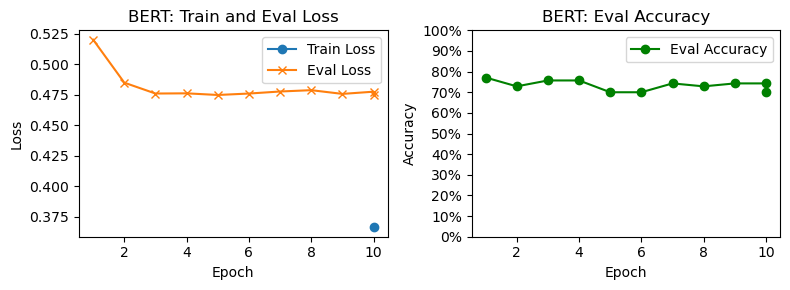

In [41]:
plot_training_result(bert_hist, 'BERT','bert_hist_1')

# 2. DeBERTa

In [42]:
deberta_name = 'microsoft/deberta-base'
deberta_tokenizer = AutoTokenizer.from_pretrained(deberta_name)

In [43]:
def preprocess_data(example):
  text = example["text"]
  encoding = deberta_tokenizer(text, padding="max_length", truncation=True, max_length=200)

  current_labels = []
  for k in labels:
    if example[k]:
      current_labels.append(1.)
    else:
      current_labels.append(0.)
  encoding["labels"] = current_labels

  return encoding

deberta_dataset = dataset.map(preprocess_data)
data_collator = DataCollatorWithPadding(tokenizer=deberta_tokenizer)

Map: 100%|██████████| 10/10 [00:00<00:00, 839.57 examples/s]


In [44]:
print(f"Tokenizer vocabulary size: {deberta_tokenizer.vocab_size}")

Tokenizer vocabulary size: 50265


In [45]:
deberta_dataset['train'][0]

{'id': 3,
 'text': 'Felt synthetic',
 'pricing': 0,
 'quality': 1,
 'delivery': 0,
 'service': 0,
 'usability': 0,
 'mismatch': 0,
 'packaging': 0,
 'input_ids': [1,
  597,
  6607,
  16807,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [46]:
deberta_dataset['test'][0]

{'id': 372,
 'text': 'This is a joke. They do not work. Do not waste time or money.',
 'pricing': 0,
 'quality': 0,
 'delivery': 0,
 'service': 0,
 'usability': 1,
 'mismatch': 0,
 'packaging': 0,
 'input_ids': [1,
  713,
  16,
  10,
  8018,
  4,
  252,
  109,
  45,
  173,
  4,
  1832,
  45,
  3844,
  86,
  50,
  418,
  4,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [47]:
deberta = AutoModelForSequenceClassification.from_pretrained(deberta_name,
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
deberta_args = TrainingArguments(
    output_dir="history/deberta",
    learning_rate=2e-5,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [49]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # BCEWithLogitsLoss for multi-label classification
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels.float())  

        return (loss, outputs) if return_outputs else loss

deberta_trainer = CustomTrainer(
    model=deberta,
    args=deberta_args,
    train_dataset=deberta_dataset['train'],
    eval_dataset=deberta_dataset['test'],
    tokenizer=deberta_tokenizer,
    compute_metrics=compute_metrics,
)

In [50]:
deberta_trainer.train()

 10%|█         | 30/300 [00:56<07:39,  1.70s/it]

{'eval_loss': 0.48234885931015015, 'eval_accuracy': 0.7857142857142857, 'eval_f1': 0.5714285714285714, 'eval_precision': 0.5555555555555556, 'eval_recall': 0.5882352941176471, 'eval_runtime': 1.5792, 'eval_samples_per_second': 6.333, 'eval_steps_per_second': 2.533, 'epoch': 1.0}


 20%|██        | 60/300 [01:51<06:54,  1.73s/it]

{'eval_loss': 0.4671704173088074, 'eval_accuracy': 0.8, 'eval_f1': 0.5882352941176471, 'eval_precision': 0.5882352941176471, 'eval_recall': 0.5882352941176471, 'eval_runtime': 1.5797, 'eval_samples_per_second': 6.33, 'eval_steps_per_second': 2.532, 'epoch': 2.0}


 30%|███       | 90/300 [02:59<05:53,  1.68s/it]

{'eval_loss': 0.45998415350914, 'eval_accuracy': 0.7714285714285715, 'eval_f1': 0.4666666666666667, 'eval_precision': 0.5384615384615384, 'eval_recall': 0.4117647058823529, 'eval_runtime': 1.5603, 'eval_samples_per_second': 6.409, 'eval_steps_per_second': 2.564, 'epoch': 3.0}


 40%|████      | 120/300 [03:52<04:57,  1.65s/it]

{'eval_loss': 0.45226508378982544, 'eval_accuracy': 0.7857142857142857, 'eval_f1': 0.4827586206896552, 'eval_precision': 0.5833333333333334, 'eval_recall': 0.4117647058823529, 'eval_runtime': 1.5183, 'eval_samples_per_second': 6.586, 'eval_steps_per_second': 2.635, 'epoch': 4.0}


 50%|█████     | 150/300 [04:45<04:08,  1.66s/it]

{'eval_loss': 0.44447073340415955, 'eval_accuracy': 0.8142857142857143, 'eval_f1': 0.5806451612903226, 'eval_precision': 0.6428571428571429, 'eval_recall': 0.5294117647058824, 'eval_runtime': 1.5555, 'eval_samples_per_second': 6.429, 'eval_steps_per_second': 2.571, 'epoch': 5.0}


 60%|██████    | 180/300 [05:38<03:20,  1.67s/it]

{'eval_loss': 0.46262621879577637, 'eval_accuracy': 0.8, 'eval_f1': 0.5, 'eval_precision': 0.6363636363636364, 'eval_recall': 0.4117647058823529, 'eval_runtime': 1.482, 'eval_samples_per_second': 6.748, 'eval_steps_per_second': 2.699, 'epoch': 6.0}


 70%|███████   | 210/300 [06:40<02:35,  1.72s/it]

{'eval_loss': 0.44677862524986267, 'eval_accuracy': 0.8, 'eval_f1': 0.5, 'eval_precision': 0.6363636363636364, 'eval_recall': 0.4117647058823529, 'eval_runtime': 1.5932, 'eval_samples_per_second': 6.277, 'eval_steps_per_second': 2.511, 'epoch': 7.0}


 80%|████████  | 240/300 [07:33<01:39,  1.65s/it]

{'eval_loss': 0.45720019936561584, 'eval_accuracy': 0.8, 'eval_f1': 0.5, 'eval_precision': 0.6363636363636364, 'eval_recall': 0.4117647058823529, 'eval_runtime': 1.4747, 'eval_samples_per_second': 6.781, 'eval_steps_per_second': 2.712, 'epoch': 8.0}


 90%|█████████ | 270/300 [08:28<00:52,  1.76s/it]

{'eval_loss': 0.46038562059402466, 'eval_accuracy': 0.8142857142857143, 'eval_f1': 0.5517241379310345, 'eval_precision': 0.6666666666666666, 'eval_recall': 0.47058823529411764, 'eval_runtime': 1.585, 'eval_samples_per_second': 6.309, 'eval_steps_per_second': 2.524, 'epoch': 9.0}


100%|██████████| 300/300 [09:36<00:00,  1.75s/it]

{'eval_loss': 0.4573690891265869, 'eval_accuracy': 0.8, 'eval_f1': 0.5, 'eval_precision': 0.6363636363636364, 'eval_recall': 0.4117647058823529, 'eval_runtime': 1.5519, 'eval_samples_per_second': 6.444, 'eval_steps_per_second': 2.577, 'epoch': 10.0}


100%|██████████| 300/300 [09:39<00:00,  1.93s/it]

{'train_runtime': 579.3638, 'train_samples_per_second': 1.553, 'train_steps_per_second': 0.518, 'train_loss': 0.3050751241048177, 'epoch': 10.0}


TrainOutput(global_step=300, training_loss=0.3050751241048177, metrics={'train_runtime': 579.3638, 'train_samples_per_second': 1.553, 'train_steps_per_second': 0.518, 'total_flos': 107792371080000.0, 'train_loss': 0.3050751241048177, 'epoch': 10.0})

In [51]:
deberta_metrics = deberta_trainer.evaluate()
print(deberta_metrics)

100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

{'eval_loss': 0.44447073340415955, 'eval_accuracy': 0.8142857142857143, 'eval_f1': 0.5806451612903226, 'eval_precision': 0.6428571428571429, 'eval_recall': 0.5294117647058824, 'eval_runtime': 1.5715, 'eval_samples_per_second': 6.363, 'eval_steps_per_second': 2.545, 'epoch': 10.0}


In [52]:
deberta_hist = pd.DataFrame(deberta_trainer.state.log_history)

print(deberta_hist)

    eval_loss  eval_accuracy   eval_f1  eval_precision  eval_recall  \
0    0.482349       0.785714  0.571429        0.555556     0.588235   
1    0.467170       0.800000  0.588235        0.588235     0.588235   
2    0.459984       0.771429  0.466667        0.538462     0.411765   
3    0.452265       0.785714  0.482759        0.583333     0.411765   
4    0.444471       0.814286  0.580645        0.642857     0.529412   
5    0.462626       0.800000  0.500000        0.636364     0.411765   
6    0.446779       0.800000  0.500000        0.636364     0.411765   
7    0.457200       0.800000  0.500000        0.636364     0.411765   
8    0.460386       0.814286  0.551724        0.666667     0.470588   
9    0.457369       0.800000  0.500000        0.636364     0.411765   
10        NaN            NaN       NaN             NaN          NaN   
11   0.444471       0.814286  0.580645        0.642857     0.529412   

    eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  ste

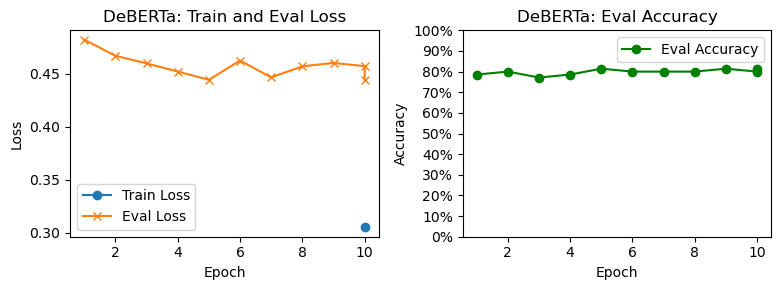

In [53]:
plot_training_result(deberta_hist, 'DeBERTa','deberta_hist_1')

# 3. DistilBERT

In [54]:
distilbert_name = 'distilbert-base-uncased'
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_name)

In [55]:
def preprocess_data(example):
  text = example["text"]
  encoding = distilbert_tokenizer(text, padding="max_length", truncation=True, max_length=200)

  current_labels = []
  for k in labels:
    if example[k]:
      current_labels.append(1.)
    else:
      current_labels.append(0.)
  encoding["labels"] = current_labels

  return encoding

distilbert_dataset = dataset.map(preprocess_data)
data_collator = DataCollatorWithPadding(tokenizer=distilbert_tokenizer)

Map: 100%|██████████| 10/10 [00:00<00:00, 967.05 examples/s]


In [56]:
distilbert_dataset['train'][0]

{'id': 3,
 'text': 'Felt synthetic',
 'pricing': 0,
 'quality': 1,
 'delivery': 0,
 'service': 0,
 'usability': 0,
 'mismatch': 0,
 'packaging': 0,
 'input_ids': [101,
  2371,
  12553,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [57]:
distilbert_dataset['test'][0]

{'id': 372,
 'text': 'This is a joke. They do not work. Do not waste time or money.',
 'pricing': 0,
 'quality': 0,
 'delivery': 0,
 'service': 0,
 'usability': 1,
 'mismatch': 0,
 'packaging': 0,
 'input_ids': [101,
  2023,
  2003,
  1037,
  8257,
  1012,
  2027,
  2079,
  2025,
  2147,
  1012,
  2079,
  2025,
  5949,
  2051,
  2030,
  2769,
  1012,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [58]:
print(f"Tokenizer vocabulary size: {distilbert_tokenizer.vocab_size}")

Tokenizer vocabulary size: 30522


In [59]:
distilbert = AutoModelForSequenceClassification.from_pretrained(distilbert_name,
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
distilbert_args = TrainingArguments(
    output_dir="history/distilbert",
    learning_rate=2e-5,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [61]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # BCEWithLogitsLoss for multi-label classification
        loss_fct = BCEWithLogitsLoss()
        loss = loss_fct(logits, labels.float())  

        return (loss, outputs) if return_outputs else loss

distilbert_trainer = CustomTrainer(
    model=distilbert,
    args=distilbert_args,
    train_dataset=distilbert_dataset['train'],
    eval_dataset=distilbert_dataset['test'],
    tokenizer=distilbert_tokenizer,
    compute_metrics=compute_metrics,
)

In [62]:
distilbert_trainer.train()

 10%|█         | 30/300 [00:20<02:46,  1.62it/s]

{'eval_loss': 0.5318495631217957, 'eval_accuracy': 0.7571428571428571, 'eval_f1': 0.37037037037037035, 'eval_precision': 0.5, 'eval_recall': 0.29411764705882354, 'eval_runtime': 0.5256, 'eval_samples_per_second': 19.025, 'eval_steps_per_second': 7.61, 'epoch': 1.0}


 20%|██        | 60/300 [00:41<02:32,  1.57it/s]

{'eval_loss': 0.4868411421775818, 'eval_accuracy': 0.7714285714285715, 'eval_f1': 0.4666666666666667, 'eval_precision': 0.5384615384615384, 'eval_recall': 0.4117647058823529, 'eval_runtime': 0.5615, 'eval_samples_per_second': 17.809, 'eval_steps_per_second': 7.123, 'epoch': 2.0}


 30%|███       | 90/300 [01:02<02:16,  1.54it/s]

{'eval_loss': 0.48066654801368713, 'eval_accuracy': 0.7571428571428571, 'eval_f1': 0.37037037037037035, 'eval_precision': 0.5, 'eval_recall': 0.29411764705882354, 'eval_runtime': 0.6396, 'eval_samples_per_second': 15.634, 'eval_steps_per_second': 6.253, 'epoch': 3.0}


 40%|████      | 120/300 [01:22<01:52,  1.60it/s]

{'eval_loss': 0.4831433892250061, 'eval_accuracy': 0.7571428571428571, 'eval_f1': 0.45161290322580644, 'eval_precision': 0.5, 'eval_recall': 0.4117647058823529, 'eval_runtime': 0.5629, 'eval_samples_per_second': 17.765, 'eval_steps_per_second': 7.106, 'epoch': 4.0}


 50%|█████     | 150/300 [01:47<01:37,  1.54it/s]

{'eval_loss': 0.4876161515712738, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.4, 'eval_precision': 0.46153846153846156, 'eval_recall': 0.35294117647058826, 'eval_runtime': 0.5689, 'eval_samples_per_second': 17.578, 'eval_steps_per_second': 7.031, 'epoch': 5.0}


 60%|██████    | 180/300 [02:08<01:21,  1.48it/s]

{'eval_loss': 0.47679099440574646, 'eval_accuracy': 0.7571428571428571, 'eval_f1': 0.48484848484848486, 'eval_precision': 0.5, 'eval_recall': 0.47058823529411764, 'eval_runtime': 0.6032, 'eval_samples_per_second': 16.577, 'eval_steps_per_second': 6.631, 'epoch': 6.0}


 70%|███████   | 210/300 [02:30<01:01,  1.46it/s]

{'eval_loss': 0.48898282647132874, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.4, 'eval_precision': 0.46153846153846156, 'eval_recall': 0.35294117647058826, 'eval_runtime': 0.6198, 'eval_samples_per_second': 16.133, 'eval_steps_per_second': 6.453, 'epoch': 7.0}


 80%|████████  | 240/300 [02:54<00:40,  1.47it/s]

{'eval_loss': 0.48630422353744507, 'eval_accuracy': 0.7285714285714285, 'eval_f1': 0.3870967741935484, 'eval_precision': 0.42857142857142855, 'eval_recall': 0.35294117647058826, 'eval_runtime': 0.6061, 'eval_samples_per_second': 16.498, 'eval_steps_per_second': 6.599, 'epoch': 8.0}


 90%|█████████ | 270/300 [03:16<00:20,  1.45it/s]

{'eval_loss': 0.489802747964859, 'eval_accuracy': 0.7285714285714285, 'eval_f1': 0.3448275862068966, 'eval_precision': 0.4166666666666667, 'eval_recall': 0.29411764705882354, 'eval_runtime': 0.6331, 'eval_samples_per_second': 15.796, 'eval_steps_per_second': 6.318, 'epoch': 9.0}


100%|██████████| 300/300 [03:42<00:00,  1.46it/s]

{'eval_loss': 0.4895349442958832, 'eval_accuracy': 0.7285714285714285, 'eval_f1': 0.3448275862068966, 'eval_precision': 0.4166666666666667, 'eval_recall': 0.29411764705882354, 'eval_runtime': 0.619, 'eval_samples_per_second': 16.154, 'eval_steps_per_second': 6.462, 'epoch': 10.0}


100%|██████████| 300/300 [03:50<00:00,  1.30it/s]

{'train_runtime': 230.6458, 'train_samples_per_second': 3.902, 'train_steps_per_second': 1.301, 'train_loss': 0.38221730550130206, 'epoch': 10.0}


TrainOutput(global_step=300, training_loss=0.38221730550130206, metrics={'train_runtime': 230.6458, 'train_samples_per_second': 3.902, 'train_steps_per_second': 1.301, 'total_flos': 46574722440000.0, 'train_loss': 0.38221730550130206, 'epoch': 10.0})

In [63]:
distilbert_metrics = distilbert_trainer.evaluate()
print(distilbert_metrics)

100%|██████████| 4/4 [00:00<00:00,  9.10it/s]

{'eval_loss': 0.47679099440574646, 'eval_accuracy': 0.7571428571428571, 'eval_f1': 0.48484848484848486, 'eval_precision': 0.5, 'eval_recall': 0.47058823529411764, 'eval_runtime': 0.6266, 'eval_samples_per_second': 15.959, 'eval_steps_per_second': 6.383, 'epoch': 10.0}


In [64]:
distilbert_hist = pd.DataFrame(distilbert_trainer.state.log_history)

print(distilbert_hist)

    eval_loss  eval_accuracy   eval_f1  eval_precision  eval_recall  \
0    0.531850       0.757143  0.370370        0.500000     0.294118   
1    0.486841       0.771429  0.466667        0.538462     0.411765   
2    0.480667       0.757143  0.370370        0.500000     0.294118   
3    0.483143       0.757143  0.451613        0.500000     0.411765   
4    0.487616       0.742857  0.400000        0.461538     0.352941   
5    0.476791       0.757143  0.484848        0.500000     0.470588   
6    0.488983       0.742857  0.400000        0.461538     0.352941   
7    0.486304       0.728571  0.387097        0.428571     0.352941   
8    0.489803       0.728571  0.344828        0.416667     0.294118   
9    0.489535       0.728571  0.344828        0.416667     0.294118   
10        NaN            NaN       NaN             NaN          NaN   
11   0.476791       0.757143  0.484848        0.500000     0.470588   

    eval_runtime  eval_samples_per_second  eval_steps_per_second  epoch  ste

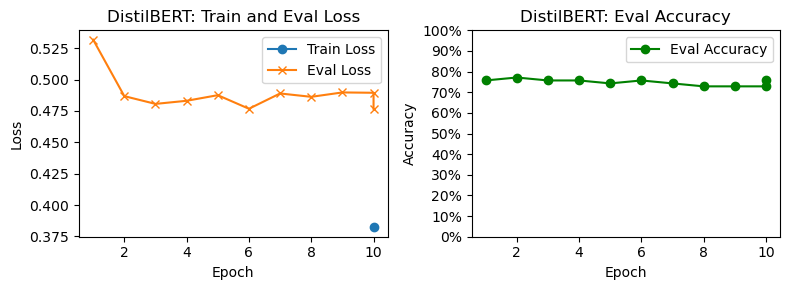

In [65]:
plot_training_result(distilbert_hist, 'DistilBERT','distilbert_hist_1')

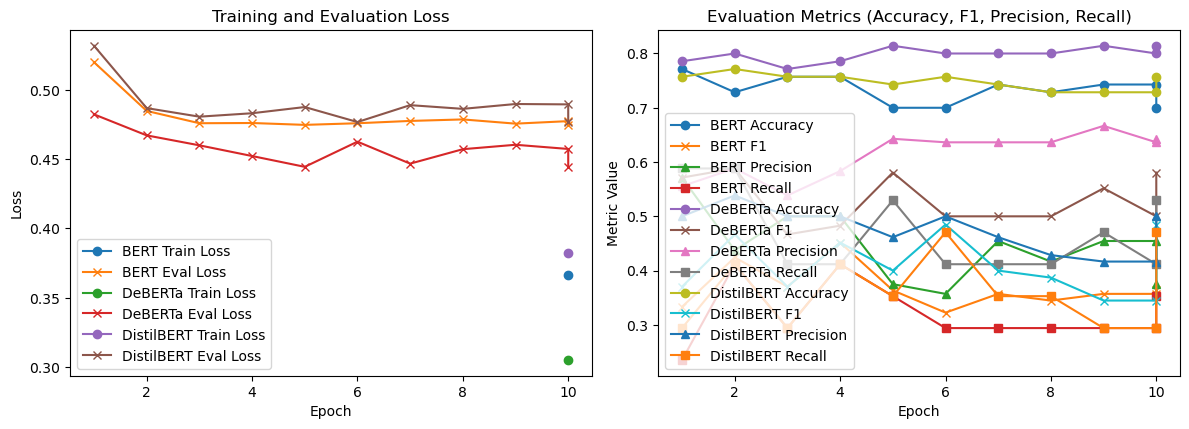

In [66]:
plot_all_results(bert_hist, deberta_hist, distilbert_hist, 'BERT', 'DeBERTa', 'DistilBERT', 'training_results_1')

In [67]:
from sklearn.metrics import classification_report

# Get predictions and labels from trained DeBERTa model
deberta_eval_preds = deberta_trainer.predict(deberta_dataset['test'])

# Sigmoid to the predictions and threshold at 0.5 for multi-label classification
predictions = (sigmoid(deberta_eval_preds.predictions) > 0.5).astype(int)

# Extract true labels
pred_labels = deberta_eval_preds.label_ids

# Generate the classification report
report = classification_report(pred_labels, predictions, zero_division=1)

print(report)

100%|██████████| 4/4 [00:01<00:00,  3.54it/s]

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.56      1.00      0.71         5
           2       1.00      0.00      0.00         1
           3       1.00      1.00      1.00         0
           4       0.80      0.80      0.80         5
           5       1.00      0.00      0.00         4
           6       1.00      0.00      0.00         1

   micro avg       0.64      0.53      0.58        17
   macro avg       0.91      0.40      0.36        17
weighted avg       0.81      0.53      0.45        17
 samples avg       0.60      0.52      0.53        17



In [68]:
# Get predictions and labels from trained BERT model
bert_eval_preds = bert_trainer.predict(bert_dataset['test'])

# Sigmoid to the predictions and threshold at 0.5 for multi-label classification
predictions = (sigmoid(bert_eval_preds.predictions) > 0.5).astype(int)

# Extract true labels
pred_labels = bert_eval_preds.label_ids

# Generate the classification report
report = classification_report(pred_labels, predictions, zero_division=1)

print(report)

100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.44      0.80      0.57         5
           2       1.00      0.00      0.00         1
           3       1.00      1.00      1.00         0
           4       0.29      0.40      0.33         5
           5       1.00      0.00      0.00         4
           6       1.00      0.00      0.00         1

   micro avg       0.38      0.35      0.36        17
   macro avg       0.82      0.31      0.27        17
weighted avg       0.63      0.35      0.27        17
 samples avg       0.40      0.36      0.32        17



In [69]:
# Get predictions and labels from trained DistilBERT model
distilbert_eval_preds = distilbert_trainer.predict(distilbert_dataset['test'])

# Sigmoid to the predictions and threshold at 0.5 for multi-label classification
predictions = (sigmoid(distilbert_eval_preds.predictions) > 0.5).astype(int)

# Extract true labels
pred_labels = distilbert_eval_preds.label_ids

# Generate the classification report
report = classification_report(pred_labels, predictions, zero_division=1)

print(report)

100%|██████████| 4/4 [00:00<00:00,  9.04it/s]

              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       0.44      0.80      0.57         5
           2       1.00      0.00      0.00         1
           3       1.00      1.00      1.00         0
           4       0.57      0.80      0.67         5
           5       1.00      0.00      0.00         4
           6       1.00      0.00      0.00         1

   micro avg       0.50      0.47      0.48        17
   macro avg       0.86      0.37      0.32        17
weighted avg       0.71      0.47      0.36        17
 samples avg       0.55      0.44      0.40        17



In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

def plot_conf(eval_preds, model_name:str, name:str) -> None:
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Sigmoid on predictions and threshold at 0.5
    predictions = (sigmoid(eval_preds.predictions) > 0.5).astype(int)
    pred_labels = eval_preds.label_ids

    confusion_matrices = multilabel_confusion_matrix(pred_labels, predictions)

    metrics = []
    classes = [f"Class {i}" for i in range(predictions.shape[1])]

    for i, cm in enumerate(confusion_matrices):
        tn, fp, fn, tp = cm.ravel()
        metrics.append([tp, fp, tn, fn])

    metrics_df = pd.DataFrame(metrics, columns=["TP", "FP", "TN", "FN"], index=classes)

    plt.figure(figsize=(10, 6))
    sns.heatmap(metrics_df, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title(f"{model_name}")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.tight_layout()
    plt.savefig(OUT_PATH + name + '.jpg')
    plt.show()

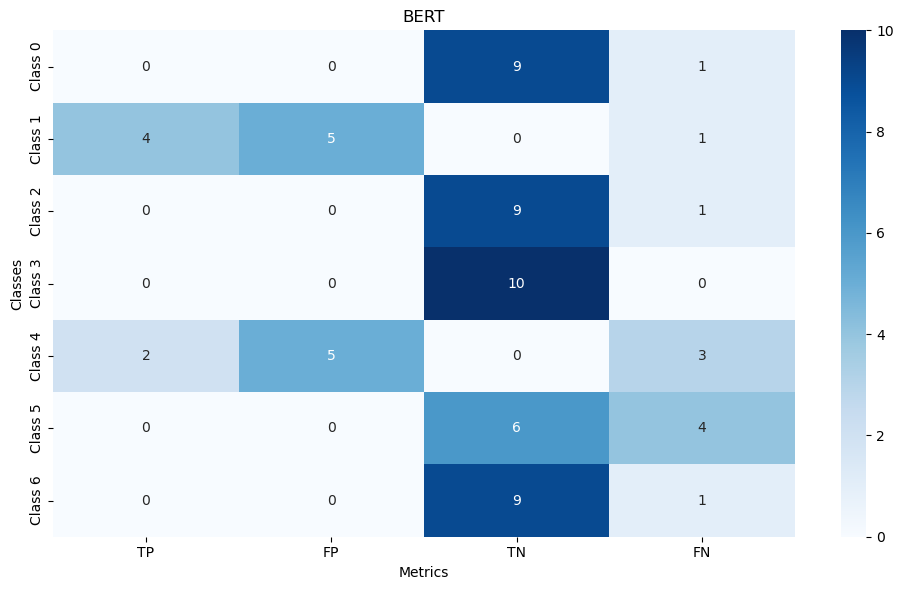

In [71]:
plot_conf(bert_eval_preds, 'BERT', 'bert_preds')

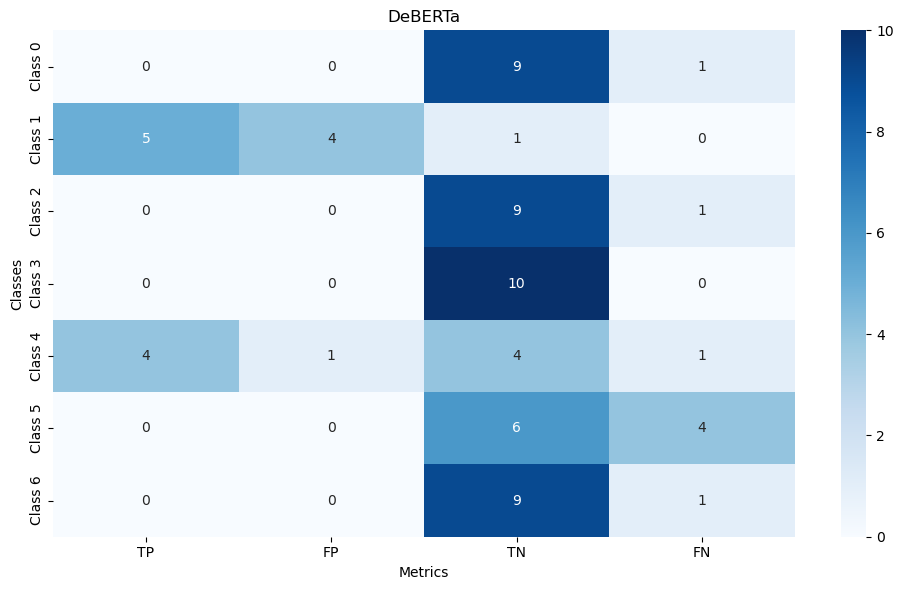

In [72]:
plot_conf(deberta_eval_preds, 'DeBERTa','deberta_preds')

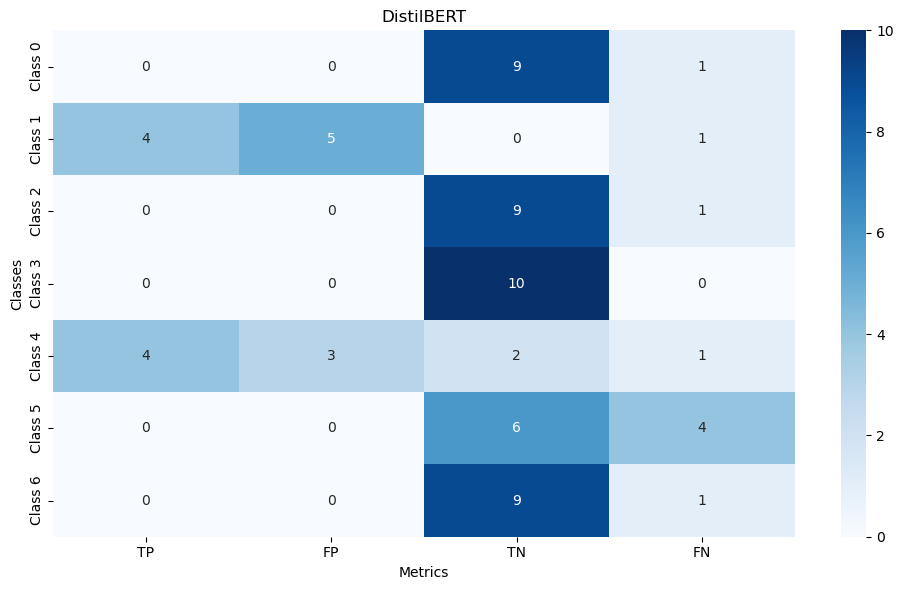

In [73]:
plot_conf(distilbert_eval_preds, 'DistilBERT','distilbert_preds')